In [2]:
import requests
import json
from collections import Counter, defaultdict
from user_agent import generate_user_agent
import numpy as np
import multiprocessing as multi
#from lxml.html import fromstring
#import requests
#from itertools import cycle
#import traceback
import matplotlib.pyplot as plt
import networkx as nx
import csv
from numpy.linalg import eigh

In [3]:
page_link = "https://www.courtlistener.com/api/rest/v3/opinions/"
page_response = requests.get(page_link)
try:
    if page_response.status_code == 200:
        number_of_opinions = page_response.json()["count"]
    else:
        print(page_response.status_code)
        print(str(requests.Timeout))
except requests.Timeout as e:
    print("It is time to timeout")
    print(str(e))

In [4]:
def chunks(n, page_list):
    """Splits the list into n chunks"""
    return np.array_split(page_list,n)
cpus = multi.cpu_count()
workers = []
page_list = ['https://www.courtlistener.com/api/rest/v3/opinions/%i' %i for i in range(number_of_opinions)]
page_bins = chunks(cpus, page_list)

In [5]:
def get_proxies():
    url = 'https://free-proxy-list.net/'
    response = requests.get(url)
    parser = fromstring(response.text)
    proxies = set()
    for i in parser.xpath('//tbody/tr')[:10]:
        if i.xpath('.//td[7][contains(text(),"yes")]'):
            proxy = ":".join([i.xpath('.//td[1]/text()')[0], i.xpath('.//td[2]/text()')[0]])
            proxies.add(proxy)
    return proxies

In [6]:
def perform_extraction(page_ranges):
    #Mine all the opinions from the court listener API
    opinions = defaultdict()
    for page in page_ranges:
        page_response = requests.get(page, proxies={"http": "62.133.191.116", "https": "62.133.191.116"})
        try:
            if page_response.status_code == 200:
                json = page_response.json()
                opinions[json["resource_uri"]] = json["opinions_cited"]
            else:
                print(page_response.status_code)
                print(str(requests.Timeout))
        except requests.Timeout as e:
            print("It is time to timeout")
            print(str(e))
        file_name = multi.current_process().name+'.txt'
        f= open(file_name,"w+")
        f.write(str(opinions))
        f.close() 

In [11]:
for cpu in range(cpus):
    worker = multi.Process(name=str(cpu), 
                           target=perform_extraction, 
                           args=(page_bins[cpu],))
    worker.start()
    workers.append(worker)

for worker in workers:
    worker.join()

{'62.133.191.116:8080', '192.116.142.153:8080', '182.75.71.178:8080', '194.182.74.110:3128', '91.109.150.229:53281', '196.220.96.42:3128', '177.158.85.146:8080'}
{'62.133.191.116:8080', '192.116.142.153:8080', '182.75.71.178:8080', '194.182.74.110:3128', '91.109.150.229:53281', '196.220.96.42:3128', '177.158.85.146:8080'}
{'62.133.191.116:8080', '192.116.142.153:8080', '182.75.71.178:8080', '194.182.74.110:3128', '91.109.150.229:53281', '196.220.96.42:3128', '177.158.85.146:8080'}
{'62.133.191.116:8080', '192.116.142.153:8080', '182.75.71.178:8080', '194.182.74.110:3128', '91.109.150.229:53281', '196.220.96.42:3128', '177.158.85.146:8080'}


Process 0:
Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/urllib3/connectionpool.py", line 595, in urlopen
    self._prepare_proxy(conn)
  File "/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/urllib3/connectionpool.py", line 816, in _prepare_proxy
    conn.connect()
  File "/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/urllib3/connection.py", line 294, in connect
    self._tunnel()
  File "/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/http/client.py", line 919, in _tunnel
    message.strip()))
OSError: Tunnel connection failed: 400 Bad Request

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/pyt

urllib3.exceptions.MaxRetryError: HTTPSConnectionPool(host='www.courtlistener.com', port=443): Max retries exceeded with url: /api/rest/v3/opinions/2043432 (Caused by ProxyError('Cannot connect to proxy.', OSError('Tunnel connection failed: 400 Bad Request',)))

During handling of the above exception, another exception occurred:

  File "/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/requests/api.py", line 72, in get
    return request('get', url, params=params, **kwargs)
Traceback (most recent call last):

During handling of the above exception, another exception occurred:

  File "/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/requests/api.py", line 58, in request
    return session.request(method=method, url=url, **kwargs)
  File "/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/requests/adapters.py", line 440, in send


In [22]:
opinions = []
with open('all.csv', newline='') as f:
    reader = csv.reader(f)
    next(reader, None)  # skip the headers
    for row in reader:
        if len(opinions) < 20000:
            opinions.append(row)

In [23]:
graph = nx.DiGraph()
for opinion in opinions:
    graph.add_edges_from([(opinion[0], opinion[1])])
graph

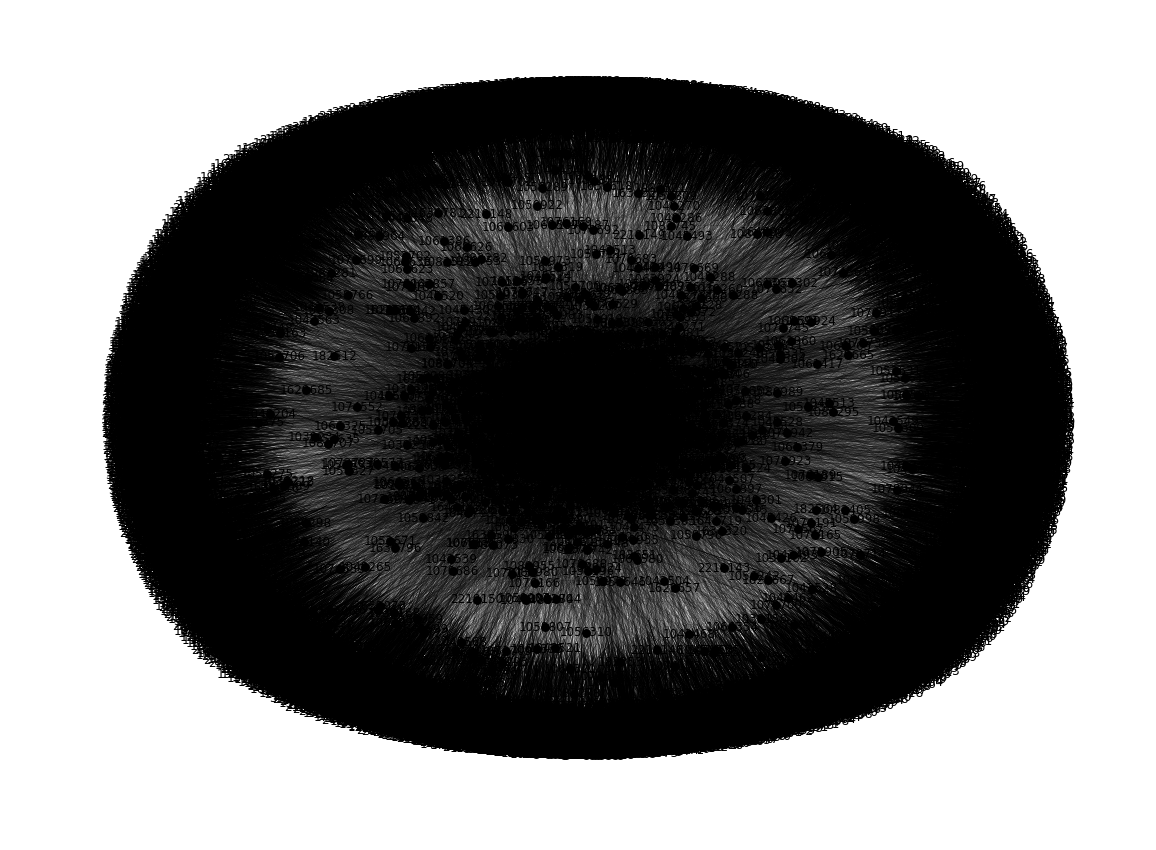

In [24]:
%matplotlib inline
plt.figure(figsize=(20,15))
nx.draw_networkx(graph, node_size=80, pos = nx.spring_layout(graph), node_color='black', linewidths=0, width=0.1)
plt.axis('off')
plt.savefig("opinion-graph", dpi=None, facecolor='w', edgecolor='w',
    orientation='portrait',
    transparent=True, pad_inches=0.1,
    frameon=None)

In [25]:
laplacian = nx.directed_laplacian_matrix(graph)
print(laplacian)

[[  9.99996101e-01  -1.06793440e-01  -1.06793440e-01 ...,  -4.12727241e-05
   -4.12727241e-05  -3.89924355e-06]
 [ -1.06793440e-01   9.99922015e-01  -7.79848709e-05 ...,  -7.83570844e-05
   -7.83570844e-05  -4.51289258e-05]
 [ -1.06793440e-01  -7.79848709e-05   9.99922015e-01 ...,  -7.83570844e-05
   -7.83570844e-05  -4.51289258e-05]
 ..., 
 [ -4.12727241e-05  -7.83570844e-05  -7.83570844e-05 ...,   9.99922015e-01
   -7.79848709e-05  -4.12727241e-05]
 [ -4.12727241e-05  -7.83570844e-05  -7.83570844e-05 ...,  -7.79848709e-05
    9.99922015e-01  -4.12727241e-05]
 [ -3.89924355e-06  -4.51289258e-05  -4.51289258e-05 ...,  -4.12727241e-05
   -4.12727241e-05   9.99996101e-01]]


In [26]:
eig_vals, eig_vectors = eigh(laplacian.A)

In [27]:
print('eigen values\n', eig_vals)
print('eigen vectors\n',np.round(eig_vectors, 2))

eigen values
 [  9.14722288e-16   5.53709065e-01   5.84158729e-01 ...,   1.39466420e+00
   1.41630247e+00   1.44719869e+00]
eigen vectors
 [[-0.01  0.   -0.   ..., -0.   -0.    0.  ]
 [-0.01  0.   -0.   ...,  0.    0.   -0.  ]
 [-0.01  0.   -0.   ...,  0.    0.   -0.  ]
 ..., 
 [-0.01  0.   -0.   ..., -0.   -0.    0.  ]
 [-0.01  0.   -0.   ..., -0.   -0.    0.  ]
 [-0.01  0.   -0.   ..., -0.   -0.    0.  ]]


In [28]:
print('second eigen value=%.2f' % eig_vals[1])
print('second eigen vector=\n%s' % eig_vectors[:,1])
#nx.draw(graph, with_labels=True)

second eigen value=0.55
second eigen vector=
[ 0.00045442  0.00034947  0.00034947 ...,  0.00024673  0.00024673
  0.00089104]
